In [1]:
import os
import torch
import torchvision
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import pandas as pd
# from skimage import io, transform
# import numpy as np
import cupy as cp
import shutil
from pathlib import Path
from random import random

plt.ion()

In [2]:
torch.cuda.device_count()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.__version__, device

('2.6.0+cu126', device(type='cuda', index=0))

## Setting up the Data
Understanding the file structure and the structuring of the given dataset by kaggle. 

In [3]:
BATCH_SIZE = 128
IMG_HEIGHT = 32
IMG_WIDTH = 32
RANDOM_SEED = 28

root = Path("data/cifar10")

# (root/'train').rename(root/'original_train')
# (root/'test').rename(root/'original_test')

In [23]:
image_dir = r"data/cifar10/original_train/train"
csv_path = r"data/cifar10/trainLabels.csv"

In [24]:
labels_df = pd.read_csv(csv_path)
print(labels_df.head())

label_to_int = {label: idx for idx, label in enumerate(labels_df['label'].unique())}
int_to_label = {idx: label for label, idx in label_to_int.items()}

print(label_to_int)
print(int_to_label)

   id       label
0   1        frog
1   2       truck
2   3       truck
3   4        deer
4   5  automobile
{'frog': 0, 'truck': 1, 'deer': 2, 'automobile': 3, 'bird': 4, 'horse': 5, 'ship': 6, 'cat': 7, 'dog': 8, 'airplane': 9}
{0: 'frog', 1: 'truck', 2: 'deer', 3: 'automobile', 4: 'bird', 5: 'horse', 6: 'ship', 7: 'cat', 8: 'dog', 9: 'airplane'}


In [6]:
len(labels_df)

50000

In [4]:
random_seed = 42
torch.manual_seed(random_seed);

In [8]:
image_paths = labels_df['id'].apply(lambda x: os.path.join(image_dir, f"{x}.png"))
labels = labels_df['label'].apply(lambda x: label_to_int[x])    # convert labels to int values according to label_to_int dict

In [9]:
print(image_paths.head())
print(labels.head())

0    data/cifar10/original_train/train/1.png
1    data/cifar10/original_train/train/2.png
2    data/cifar10/original_train/train/3.png
3    data/cifar10/original_train/train/4.png
4    data/cifar10/original_train/train/5.png
Name: id, dtype: object
0    0
1    1
2    1
3    2
4    3
Name: label, dtype: int64


## Setting up the Training and Pre-Processing

In [16]:
from PIL import Image

class Cifar10Dataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image = Image.open(self.image_paths.iloc[index])
        get_label = self.labels.iloc[index]
        
        if self.transform is not None:
            image = self.transform(image)

        if self.transform is None:
            image = ToTensor()(image)
            
        label_tensor = torch.tensor(get_label).type(torch.LongTensor)
        
        return image, label_tensor

```Python
# Data Loaeders for one fold


train_dataset = Cifar10Dataset(train_paths, train_labels)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

mean = 0.0
std = 0.0
for images, _ in train_loader:
    batch_samples = images.size(0)  # batch size (the last batch can have smaller size)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
```

This code helped me to find the mean and standard deviation of our Cifar10 Dataset, we shall put it in `transofrms.Normalize()` function. By this we can normalize the Tensors accordingly.



In [ ]:
# mean /= len(train_loader.dataset)
# std /= len(train_loader.dataset)
# print(mean, std)

In [11]:
# Getting the image transformation on the training set
train_transform = transforms.Compose([
    # transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(10),
    # transforms.ColorJitter(brightness=0, contrast=0, saturation=0),
    transforms.ToTensor(),
    transforms.Normalize(mean= [0.4914, 0.4822, 0.4465],
                         std= [0.2025, 0.1996, 0.2012]),
    # transforms.RandomErasing(p=float(random_seed / 100), scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

In [20]:
valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
])


In [13]:
transformed_dataset = Cifar10Dataset(image_paths, labels, transform=train_transform)
# val_dataset = Cifar10Dataset(valid_paths, valid_labels, transform=valid_transform)
transformed_loader = DataLoader(transformed_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)


In [ ]:
for x, y in transformed_dataset:
    print(x.device, y.device)
    print(x.shape, y.shape)
    print(y)
    break

In [14]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(cp.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71333337..1.777447].


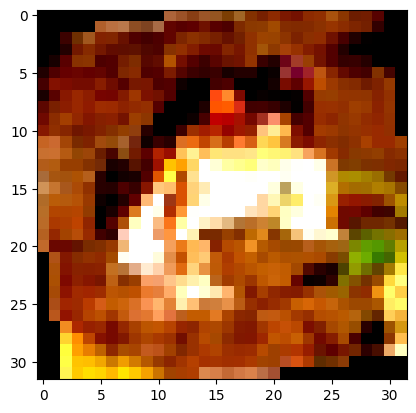

tensor(0)


In [15]:
for images, labels in transformed_dataset:
    img = images
    label = labels
    # print(torch.max(img), torch.min(img))
    imshow(img)
    print(label)
    break

## Defining the Model

We will be using a Convolutional Neural Network, with Batch Normalisation, `ReLU` activation function and `Max-Pooling` of 2 x 2 size


First we define a class for the model to refer to during the training of the model.

In [5]:
class Cifar10ModelBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        preds = self(images)  # Get Predictions
        loss = F.cross_entropy(preds, labels)
        return loss
    
    def valid_step(self, batch):
        images, labels = batch
        preds = self(images)
        loss = F.cross_entropy(preds, labels)
        acc = accuracy(preds, labels)           # Function to calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def valid_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()

        batch_accuracy = [x['val_acc'] for x in outputs]
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_accuracy.item()}
    
    def epoch_end(self, epoch, result):
        print(f'Epoch [{epoch+1}]: Loss of the Model = {result["val_loss"]:.4f}, Accuracy of the Model = {100 * result["val_acc"]:.2f} %')

    
def accuracy(outputs, label):
    _, preds = torch.max(outputs, dim= 1)   # Get the index of the max log-probability
    return torch.tensor(torch.sum(preds == label).item() / len(preds))

We'll use `nn.Sequential` to chain the layers and activations functions into a single network architecture.

In [7]:
class Cifar10Model(Cifar10ModelBase):
    def __init__(self):
        super().__init__()
        # Le-Net Based Architecture
        self.network = nn.Sequential(

            # Normalise the input
            nn.BatchNorm2d(3),         # Output: 3 x 32 x 32

            # CONV => LeakyRELU => BatchNORM => POOL => DROPOUT
            nn.Conv2d(3, 32, kernel_size= 3, stride= 1, padding= 0),    # Output: [(W−K+2P)/S]+1 = [(32 - 3 + 0) / 1] + 1 = 29 = (32, 30, 30)
            # nn.Conv2d(64, 128, kernel_size= 3, stride= 1, padding= 1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),     # Output: absolut([(W - K) / S] + 1) = 32 x 15 x 15
            nn.Dropout2d(0.2),

            # CONV => BatchNORM => CONV => RELU => POOL => DROPOUT
            nn.Conv2d(32, 64, kernel_size= 4, stride= 1, padding= 0),   # Output: [(15 - 4)/1] + 1 = 12
            # nn.Conv2d(128, 64, kernel_size= 3, stride= 1, padding= 1),
            nn.LeakyReLU(),            
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),     # Output: = 64 x 6 x 6
            nn.Dropout2d(0.2),

            # CONV => BatchNORM => CONV => RELU => POOL => DROPOUT
            nn.Conv2d(64, 128, kernel_size= 3, stride= 1, padding= 0),   # Output: [(6 - 3)/1] + 1 = 4 = (128, 4, 4)
            # nn.Conv2d(128, 64, kernel_size= 3, stride= 1, padding= 1),
            nn.LeakyReLU(),      
            nn.Conv2d(128, 256, kernel_size= 3, stride= 1, padding= 0),   # Output: [(4 - 3)/1] + 1 = 2 = (256, 2, 2)
            nn.LeakyReLU(),           
            nn.BatchNorm2d(256),
            nn.AvgPool2d(1, 1),     # Output: = 256 x 2 x 2
            nn.Dropout2d(0.2),


            nn.Flatten(),           # Flatten the output
            nn.Linear(256 * 2 * 2, 512),
            # nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10),
        )

    def forward(self, xb):
        return self.network(xb)



Let's verify that the model produces the expected output on a batch of training data. The 10 outputs for each image can be interpreted as probabilities for the 10 target classes (after applying softmax), and the class with the highest probability is chosen as the label predicted by the model for the input image.

In [ ]:
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"CUDA Device Name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No CUDA Device'}")

In [8]:
model = Cifar10Model().cuda()
# print(model)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 32, 30, 30]             896
         LeakyReLU-3           [-1, 32, 30, 30]               0
       BatchNorm2d-4           [-1, 32, 30, 30]              64
         MaxPool2d-5           [-1, 32, 15, 15]               0
         Dropout2d-6           [-1, 32, 15, 15]               0
            Conv2d-7           [-1, 64, 12, 12]          32,832
         LeakyReLU-8           [-1, 64, 12, 12]               0
       BatchNorm2d-9           [-1, 64, 12, 12]             128
        MaxPool2d-10             [-1, 64, 6, 6]               0
        Dropout2d-11             [-1, 64, 6, 6]               0
           Conv2d-12            [-1, 128, 4, 4]          73,856
        LeakyReLU-13            [-1, 128, 4, 4]               0
           Conv2d-14            [-1, 25

## Moving to GPU

We have made our model to run on the GPU, by calling the class object with a `.cuda()` parameter. Now we move our data to the GPU as-well

In [9]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dataset, device, SAMPLER=None):
        self.dl = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=0, sampler=SAMPLER)
        self.device = device
        super().__init__(self)
        # self.batch = dataset
        
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)
    
    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    


In [19]:
transformed_loader_gpu = DeviceDataLoader(transformed_dataset, device)

## Training The Model!!

We define a `fit` and `evaluate` function to train the model using Stochastic Gradient Descent and evaluate its perfromance based on the validaton data.

In [10]:
def evaluate(model, val_loader):
    with torch.no_grad():
        outputs = [model.valid_step(batch) for batch in val_loader]
        return model.valid_epoch_end(outputs)
    
def fit(epochs, model, train_loader, valid_loader, lr=0.01, opt_func= torch.optim.SGD, getScheduler=None):
    history = []
    if opt_func == torch.optim.SGD:
        opt_func = opt_func(model.parameters(), lr)

    for epoch in range(epochs):
        # Training
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            opt_func.step()
            opt_func.zero_grad()

        # Validation
        result = evaluate(model, valid_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        if getScheduler is not None:
            val_loss = sum(result['val_loss']) / len(valid_loader)
            getScheduler.step(val_loss)
    return history

In [11]:
next(model.parameters()).is_cuda    # Check if the model is on the GPU

True

Before we begin with training, let's first evaluate the model before training

In [ ]:
for images, labels in transformed_loader_gpu:
    print('images.shape:', images.shape)
    out = model(images)
    print(images.device, labels.device)
    print(f'Labels shape: {labels.shape}')
    break

In [ ]:
evaluate(model, transformed_loader_gpu)

## Learning Rate Scheduler

In [61]:
import torch.optim.lr_scheduler as lr_scheduler

# Define optimizer and scheduler
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)

## Cross Validation
Setting up K-Fold Cross Validation from sklearn library

In [63]:
k = 4
kf = KFold(n_splits=k, random_state=random_seed, shuffle=True)

## Splitting the Data

* Using the folds to create train and valid splits
* Map ID's to image paths 

## K Fold Cross Validation 

Let's apply K-Fold cross validation on our testing dataset. We will divide the *50,000* images in to *5 folds*, so each fold will have *10,000* images.

In [ ]:
k_folds_history = []
best_accuracy = 0.0

# Stratified K-Fold Cross Validation
for fold, (train_idx, valid_idx) in enumerate(kf.split(transformed_dataset)):
    num_epochs = 10
    lr = 0.001 + (fold * (-1 * 0.0002))

    print(f"Fold {fold+1}/{k}")
    print(f"Learning Rate: {lr}")
    print("------------------")

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = SubsetRandomSampler(train_idx)
    valid_subsampler = SubsetRandomSampler(valid_idx)

    # Define data loaders for training and testing data in this fold
    train_loader = DeviceDataLoader(transformed_dataset, device, train_subsampler)
    valid_loader = DeviceDataLoader(transformed_dataset, device, valid_subsampler)

    # Define optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)


    history = fit(num_epochs, model, train_loader, valid_loader, lr=lr, opt_func=optimizer)
    # Step the scheduler at each epoch
    for epoch in range(num_epochs):
        scheduler.step()

    k_folds_history.append(history)
    print("------------------")
    min_val_loss = min(entry['val_loss'] for entry in history)
    max_val_acc = max(entry['val_acc'] for entry in history)
    print(f'Minimum Validation Loss: {min_val_loss}')
    print(f'Highest Accuracy: {max_val_acc}')
    if max_val_acc > best_accuracy:
            best_accuracy = max_val_acc
            model_save_path = f"model_fold_{fold+1}.pth"
            torch.save(model.state_dict(), model_save_path)
            print(f"Best model for fold {fold+1} saved with accuracy: {best_accuracy:.2f}%")

    print("------------------")

## Saving the Model
Am going to trianthis over night, so once the process is completed I need to save the model else I would have to spend another hour or so next time to get the fuckin model and run the stuff on it

In [ ]:
# Define the file path where the model will be saved
model_save_path = "Cifar10Trained_Lv3.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")


In [23]:
model2 = model.load_state_dict(torch.load("./model_fold_5.pth"))
model2 = model.to(device)

In [24]:
evaluate(model2, transformed_loader_gpu)

{'val_loss': 0.42458027601242065, 'val_acc': 0.8507353067398071}

In [14]:
test_images_dir = r"data/cifar10/original_test"
parent_list = sorted(os.listdir(test_images_dir), key=lambda x: int(x.split('.')[0]))
parent_list = list(map(lambda s: os.path.join(test_images_dir, f"{s}"), parent_list))

print(parent_list[:10])

['data/cifar10/original_test/1.png', 'data/cifar10/original_test/2.png', 'data/cifar10/original_test/3.png', 'data/cifar10/original_test/4.png', 'data/cifar10/original_test/5.png', 'data/cifar10/original_test/6.png', 'data/cifar10/original_test/7.png', 'data/cifar10/original_test/8.png', 'data/cifar10/original_test/9.png', 'data/cifar10/original_test/10.png']


## Working with Semi-Supervised Data
So now what we will do is take the 300k images and get their outputs in probabilities. Based on a threshold we will re-use some of the test images as train images and get a higher accuracy model! 

In [43]:
class Cifar10TrainDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        
        if self.transform is not None:
            image = self.transform(image)
        if self.transform is None:
            image = ToTensor()(image)
        
        return image

In [44]:
unlabel_data = Cifar10TrainDataset(parent_list, valid_transform)

semiTest_loader = DataLoader(unlabel_data, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.22483134..1.2448163].


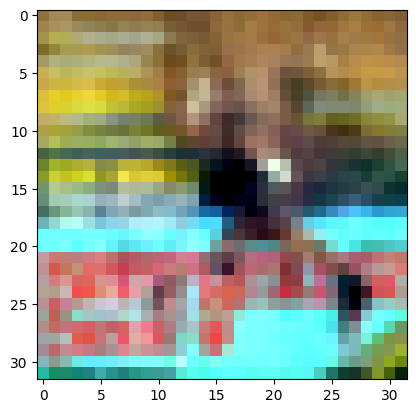

In [45]:
for images in unlabel_data:
    img = images
    # print(torch.max(img), torch.min(img))
    imshow(img)
    break

In [53]:
def generate_pseudo_labels(model, unlabeled_loader, threshold=0.95):
    """Generate pseudo-labels for unlabeled data with confidence filtering"""
    model.eval()  # Set to evaluation mode
    pseudo_labeled_data = []
    
    with torch.no_grad():
        for images in unlabeled_loader:
            print(f"Current num of Images: {images.size()}")
            images = images.to(device)
            outputs = model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidences, pseudo_labels = torch.max(probabilities, dim=1)
            
            # Select only high-confidence pseudo-labels
            high_confidence_mask = confidences > threshold
            selected_images = images[high_confidence_mask]
            selected_labels = pseudo_labels[high_confidence_mask]

            for img, label in zip(selected_images, selected_labels):
                pseudo_labeled_data.append((img.cpu(), label.cpu()))
    
    return pseudo_labeled_data

In [47]:
# Combining the two datasets
from torch.utils.data import ConcatDataset, TensorDataset

def create_augmented_dataset(train_dataset, pseudo_labeled_data):
    """Merge labeled dataset with high-confidence pseudo-labeled data"""
    pseudo_images, pseudo_labels = zip(*pseudo_labeled_data)
    pseudo_dataset = TensorDataset(torch.stack(pseudo_images), torch.tensor(pseudo_labels))

    # Merge original labeled dataset with pseudo-labeled dataset
    combined_dataset = ConcatDataset([train_dataset, pseudo_dataset])
    return combined_dataset

In [54]:
# Generate pseudo-labels from the trained model
pseudo_labeled_data = generate_pseudo_labels(model, semiTest_loader, threshold=0.95)

# Combine pseudo-labeled data with original training data
augmented_dataset = create_augmented_dataset(transformed_dataset, pseudo_labeled_data)

Current num of Images: torch.Size([128, 3, 32, 32])
Current num of Images: torch.Size([128, 3, 32, 32])
Current num of Images: torch.Size([128, 3, 32, 32])
Current num of Images: torch.Size([128, 3, 32, 32])
Current num of Images: torch.Size([128, 3, 32, 32])
Current num of Images: torch.Size([128, 3, 32, 32])
Current num of Images: torch.Size([128, 3, 32, 32])
Current num of Images: torch.Size([128, 3, 32, 32])
Current num of Images: torch.Size([128, 3, 32, 32])
Current num of Images: torch.Size([128, 3, 32, 32])
Current num of Images: torch.Size([128, 3, 32, 32])
Current num of Images: torch.Size([128, 3, 32, 32])
Current num of Images: torch.Size([128, 3, 32, 32])
Current num of Images: torch.Size([128, 3, 32, 32])
Current num of Images: torch.Size([128, 3, 32, 32])
Current num of Images: torch.Size([128, 3, 32, 32])
Current num of Images: torch.Size([128, 3, 32, 32])
Current num of Images: torch.Size([128, 3, 32, 32])
Current num of Images: torch.Size([128, 3, 32, 32])
Current num 

In [57]:
augmented_dataset.__len__()

150255

## Retraining on the larger dataset!

In [64]:
nK_folds_history = []
best_accuracy = 0.0

# Stratified K-Fold Cross Validation
for fold, (train_idx, valid_idx) in enumerate(kf.split(transformed_dataset)):
    num_epochs = 5
    lr = 0.0001 + (fold * (-1 * 0.00002))

    print(f"Fold {fold+1}/{k}")
    print(f"Learning Rate: {lr}")
    print("------------------")

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = SubsetRandomSampler(train_idx)
    valid_subsampler = SubsetRandomSampler(valid_idx)

    # Define data loaders for training and testing data in this fold
    train_loader = DeviceDataLoader(transformed_dataset, device, train_subsampler)
    valid_loader = DeviceDataLoader(transformed_dataset, device, valid_subsampler)

    # Define optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)


    history = fit(num_epochs, model, train_loader, valid_loader, lr=lr, opt_func=optimizer)
    # Step the scheduler at each epoch
    for epoch in range(num_epochs):
        scheduler.step()

    nK_folds_history.append(history)
    print("------------------")
    min_val_loss = min(entry['val_loss'] for entry in history)
    max_val_acc = max(entry['val_acc'] for entry in history)
    print(f'Minimum Validation Loss: {min_val_loss}')
    print(f'Highest Accuracy: {max_val_acc}')
    if max_val_acc > best_accuracy:
            best_accuracy = max_val_acc
            model_save_path = f"retrained_model_fold_{fold+1}.pth"
            torch.save(model.state_dict(), model_save_path)
            print(f"Best model for fold {fold+1} saved with accuracy: {best_accuracy*100:.1f}%")

    print("------------------")

Fold 1/4
Learning Rate: 0.0001
------------------
Epoch [1]: Loss of the Model = 0.1648, Accuracy of the Model = 94.12 %
Epoch [2]: Loss of the Model = 0.1737, Accuracy of the Model = 94.04 %
Epoch [3]: Loss of the Model = 0.1699, Accuracy of the Model = 94.10 %
Epoch [4]: Loss of the Model = 0.1748, Accuracy of the Model = 93.88 %
Epoch [5]: Loss of the Model = 0.1776, Accuracy of the Model = 93.91 %
------------------
Minimum Validation Loss: 0.16476570069789886
Highest Accuracy: 0.9411898255348206
Best model for fold 1 saved with accuracy: 94.1%
------------------
Fold 2/4
Learning Rate: 8e-05
------------------
Epoch [1]: Loss of the Model = 0.1191, Accuracy of the Model = 96.10 %
Epoch [2]: Loss of the Model = 0.1118, Accuracy of the Model = 96.45 %
Epoch [3]: Loss of the Model = 0.1208, Accuracy of the Model = 95.91 %
Epoch [4]: Loss of the Model = 0.1211, Accuracy of the Model = 95.89 %
Epoch [5]: Loss of the Model = 0.1239, Accuracy of the Model = 95.74 %
------------------
Min

In [18]:
test_images = sorted(os.listdir(test_images_dir), key=lambda x: int(x.split('.')[0]))

In [12]:
# del model2

model3 = model.load_state_dict(torch.load("./retrained_model_fold_4.pth"))
model3 = model.to(device)

In [ ]:
with open('data/cifar10/Submission_Lv1.csv', 'w') as file:
    file.write("id,label\n")
    for img_path in test_images:
        # print(img_path[1])
        image = os.path.join(test_images_dir, img_path)
        image = Image.open(image)
        image = valid_transform(image)
        image = image.unsqueeze(0)
        image = image.to(device)

        output = model3(image)
        _, predicted = torch.max(output, 1)
        predicted = int_to_label[predicted.item()]
        # print("Prediction Completed!")

        num = int(img_path.split('.')[0])
        file.write(f"{num},{predicted}\n")
        
        if num % 10000 == 0:
            print(f"Batch {num // 10000} done")
        if num == 300000:
            print("Finished!!!")
            

Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
Batch 16 done
Batch 17 done
Batch 18 done
Batch 19 done
Batch 20 done
Batch 21 done
Batch 22 done
Batch 23 done
Batch 24 done
Batch 25 done
Batch 26 done
Batch 27 done
Batch 28 done
Batch 29 done
Batch 30 done
Finished!!!
